In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thesis-data/Nebuli_data.csv
/kaggle/input/thesis-data/preprocessed_nlp_data.csv


In [2]:
!pip install --upgrade nltk
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 36.6 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819467 sha256=121e29f80804490c6d9f8eee4d2a8e63682f32e870174a23fc25c0f631d4fa21
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76

In [3]:
import pandas as pd
import numpy as np
from plotly import graph_objs as go
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import nltk
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer, PorterStemmer
# from sklearn.feature_extraction.text import TfidfVectorizer
# dler = nltk.downloader.Downloader()
# dler._update_index()
nltk.data.path.append('/kaggle/output')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.corpus import  wordnet

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
data_df = pd.read_csv('/kaggle/input/thesis-data/Nebuli_data.csv',index_col=0)
data_df.head()


id                                              title  \
0  201               SGI Launches Open Storage Initiative   
1  270  IBM Releases Next Generation Storage Virtualis...   
2  293  IBM Launches New Mainframe and Storage Systems...   
3  337  Oracle 10g database sets the pace for a world ...   
4  339   IBM Releases New Automated DB2 Database Software   

                                           introtext  \
0  Silicon Graphics has today announced the Open ...   
1  IBM has revealed its TotalStorage SAN File Sys...   
2  Celebrating the 40th anniversary of the IBM Sy...   
3  Oracle is setting the pace for the highest per...   
4  IBM has today announced the release of its new...   

                                            fulltext  cat_id          class_2  \
0  Silicon Graphics has today announced the Open ...    1836  Data Management   
1  IBM has revealed its TotalStorage SAN File Sys...    1836  Data Management   
2   Celebrating the 40th anniversary of the IBM S...    1836  Data Management   
3   Tests were performed on an eight-node cluster...    1836  Data Management   
4   The new database software promises to deliver...    1836  Data Management   

   level  cat_parent_id parent_title  grandparent_id grandparent_title  
0      3           2100     Big Data            2096          Channels  
1      3           2100     Big Data            2096          Channels  
2      3           2100     Big Data            2096          Channels  
3      3           2100     Big Data            2096          Channels  
4      3           2100     Big Data            2096          Channels

In [5]:
len(data_df.id.unique())

9413

In [6]:
data_df.isnull().sum()

id                     0
title                  0
introtext            378
fulltext             259
cat_id                 0
class_2                0
level                  0
cat_parent_id          0
parent_title           0
grandparent_id         0
grandparent_title      0
dtype: int64

In [7]:
len(data_df[data_df.isnull()==False])
# data_df = data_df[data_df['parent_title']!='Channels']


9413

In [8]:
k = data_df.groupby(['parent_title']).agg({'id':'count'}).reset_index()
fig = px.bar(k, y="parent_title",x='id')
fig.show()

In [9]:
data_df.loc[data_df['parent_title'] == 'Channels', 'parent_title'] = data_df['class_2']
data_df.loc[data_df['cat_parent_id'] == '2096', 'cat_parent_id'] = data_df['cat_id']
data_df.parent_title.unique()

array(['Big Data', 'Nanotechnology', 'Alternative Energy', 'Bio-IT',
       'Healthcare Technology', 'Genomics', 'Clinical Research',
       'Disease Processes', 'Cancer Research', 'Bioengineering',
       'Green Biology', 'Proteomics', 'Stem Cells', 'Neuroscience',
       'Material Science', 'Cell Biology', 'Food Bioscience',
       'Biopollution', 'Social Science', 'Astrobiology'], dtype=object)

In [10]:
k = data_df.groupby(['parent_title']).agg({'id':'count'}).reset_index()
k = k[k['id']>50]
fig = px.bar(k, y="parent_title",x='id')
fig.show()


In [11]:
def preprocess_text(text):
    # Tokenization
    text= ''.join(e for e in text if e.isalnum() or e in {' ','\n'})
    tokens = nltk.word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
#     lemmatizer = WordNetLemmatizer()
#     tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [PorterStemmer().stem(token) for token in tokens]
    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

data_df['title_cleaned'] = data_df['title'].apply(preprocess_text)
data_df['introtext'] = data_df['introtext'].astype(str)
data_df['introtext_cleaned'] =data_df['introtext'].apply(preprocess_text)
data_df['fulltext'] = data_df['fulltext'].astype(str)
data_df['fulltext_cleaned'] =data_df['fulltext'].apply(preprocess_text)
data_df.to_csv('preprocessed_nlp_data.csv')
data_df.head()

id                                              title  \
0  201               SGI Launches Open Storage Initiative   
1  270  IBM Releases Next Generation Storage Virtualis...   
2  293  IBM Launches New Mainframe and Storage Systems...   
3  337  Oracle 10g database sets the pace for a world ...   
4  339   IBM Releases New Automated DB2 Database Software   

                                           introtext  \
0  Silicon Graphics has today announced the Open ...   
1  IBM has revealed its TotalStorage SAN File Sys...   
2  Celebrating the 40th anniversary of the IBM Sy...   
3  Oracle is setting the pace for the highest per...   
4  IBM has today announced the release of its new...   

                                            fulltext  cat_id          class_2  \
0  Silicon Graphics has today announced the Open ...    1836  Data Management   
1  IBM has revealed its TotalStorage SAN File Sys...    1836  Data Management   
2   Celebrating the 40th anniversary of the IBM S...    1836  Data Management   
3   Tests were performed on an eight-node cluster...    1836  Data Management   
4   The new database software promises to deliver...    1836  Data Management   

   level  cat_parent_id parent_title  grandparent_id grandparent_title  \
0      3           2100     Big Data            2096          Channels   
1      3           2100     Big Data            2096          Channels   
2      3           2100     Big Data            2096          Channels   
3      3           2100     Big Data            2096          Channels   
4      3           2100     Big Data            2096          Channels   

                                       title_cleaned  \
0                       sgi launch open storag initi   
1  ibm releas next gener storag virtualis softwar...   
2  ibm launch new mainfram storag system celebr 4...   
3    oracl 10g databas set pace world record perform   
4           ibm releas new autom db2 databas softwar   

                                   introtext_cleaned  \
0  silicon graphic today announc open storag init...   
1  ibm reveal totalstorag san file system softwar...   
2  celebr 40th anniversari ibm system360 mainfram...   
3  oracl set pace highest perform oracl databas 1...   
4  ibm today announc releas new db2 univers datab...   

                                    fulltext_cleaned  
0  silicon graphic today announc open storag init...  
1  ibm reveal totalstorag san file system softwar...  
2  celebr 40th anniversari ibm system360 mainfram...  
3  test perform eightnod cluster industrystandard...  
4  new databas softwar promis deliv number key im...

In [12]:
nlp_df = pd.read_csv('/kaggle/input/thesis-data/preprocessed_nlp_data.csv',index_col=0)
nlp_df.head()

id                                              title  \
0  201               SGI Launches Open Storage Initiative   
1  270  IBM Releases Next Generation Storage Virtualis...   
2  293  IBM Launches New Mainframe and Storage Systems...   
3  337  Oracle 10g database sets the pace for a world ...   
4  339   IBM Releases New Automated DB2 Database Software   

                                           introtext  \
0  Silicon Graphics has today announced the Open ...   
1  IBM has revealed its TotalStorage SAN File Sys...   
2  Celebrating the 40th anniversary of the IBM Sy...   
3  Oracle is setting the pace for the highest per...   
4  IBM has today announced the release of its new...   

                                            fulltext  cat_id          class_2  \
0  Silicon Graphics has today announced the Open ...    1836  Data Management   
1  IBM has revealed its TotalStorage SAN File Sys...    1836  Data Management   
2   Celebrating the 40th anniversary of the IBM S...    1836  Data Management   
3   Tests were performed on an eight-node cluster...    1836  Data Management   
4   The new database software promises to deliver...    1836  Data Management   

   level  cat_parent_id parent_title  grandparent_id grandparent_title  \
0      3           2100     Big Data            2096          Channels   
1      3           2100     Big Data            2096          Channels   
2      3           2100     Big Data            2096          Channels   
3      3           2100     Big Data            2096          Channels   
4      3           2100     Big Data            2096          Channels   

                                       title_cleaned  \
0                       sgi launch open storag initi   
1  ibm releas next gener storag virtualis softwar...   
2  ibm launch new mainfram storag system celebr 4...   
3    oracl 10g databas set pace world record perform   
4           ibm releas new autom db2 databas softwar   

                                   introtext_cleaned  \
0  silicon graphic today announc open storag init...   
1  ibm reveal totalstorag san file system softwar...   
2  celebr 40th anniversari ibm system360 mainfram...   
3  oracl set pace highest perform oracl databas 1...   
4  ibm today announc releas new db2 univers datab...   

                                    fulltext_cleaned  
0  silicon graphic today announc open storag init...  
1  ibm reveal totalstorag san file system softwar...  
2  celebr 40th anniversari ibm system360 mainfram...  
3  test perform eightnod cluster industrystandard...  
4  new databas softwar promis deliv number key im...

In [13]:
feature_names_list = []
bag_nlp_df = data_df.copy(deep=True)
vectorizer = CountVectorizer()
# bag_of_words = vectorizer.fit_transform(nlp_df['title_cleaned'].values.astype('U'))
# feature_names = vectorizer.get_feature_names_out()
# bow_df = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)
# feature_names_list.extend(feature_names)
# bag_nlp_df = pd.concat([bag_nlp_df, bow_df], axis=1)

# bag_of_words = vectorizer.fit_transform(nlp_df['introtext_cleaned'].values.astype('U'))
# feature_names = vectorizer.get_feature_names_out()
# bow_df = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)
# feature_names_list.extend(feature_names)
# bag_nlp_df = pd.concat([bag_nlp_df, bow_df], axis=1)

bag_of_words = vectorizer.fit_transform(nlp_df['fulltext_cleaned'].values.astype('U'))
feature_names = vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)
bag_nlp_df = pd.concat([bag_nlp_df, bow_df], axis=1)
feature_names_list.extend(feature_names)
bag_nlp_df.head()

id                                              title  \
0  201               SGI Launches Open Storage Initiative   
1  270  IBM Releases Next Generation Storage Virtualis...   
2  293  IBM Launches New Mainframe and Storage Systems...   
3  337  Oracle 10g database sets the pace for a world ...   
4  339   IBM Releases New Automated DB2 Database Software   

                                           introtext  \
0  Silicon Graphics has today announced the Open ...   
1  IBM has revealed its TotalStorage SAN File Sys...   
2  Celebrating the 40th anniversary of the IBM Sy...   
3  Oracle is setting the pace for the highest per...   
4  IBM has today announced the release of its new...   

                                            fulltext  cat_id          class_2  \
0  Silicon Graphics has today announced the Open ...    1836  Data Management   
1  IBM has revealed its TotalStorage SAN File Sys...    1836  Data Management   
2   Celebrating the 40th anniversary of the IBM S...    1836  Data Management   
3   Tests were performed on an eight-node cluster...    1836  Data Management   
4   The new database software promises to deliver...    1836  Data Management   

   level  cat_parent_id parent_title  grandparent_id  ... ãsa ãscar ãse  \
0      3           2100     Big Data            2096  ...   0     0   0   
1      3           2100     Big Data            2096  ...   0     0   0   
2      3           2100     Big Data            2096  ...   0     0   0   
3      3           2100     Big Data            2096  ...   0     0   0   
4      3           2100     Big Data            2096  ...   0     0   0   

  ãsecretase1  ãslaug  ãthe  ãverkalix  ãystein  ãzer  ãzge  
0           0       0     0          0        0     0     0  
1           0       0     0          0        0     0     0  
2           0       0     0          0        0     0     0  
3           0       0     0          0        0     0     0  
4           0       0     0          0        0     0     0  

[5 rows x 106380 columns]

In [14]:
df_bow_sklearn = pd.DataFrame(bag_of_words.toarray(),columns=feature_names)

In [15]:
max(df_bow_sklearn.astype('bool').sum())

8092

(array([124.,  82.,  42.,  54.,  28.,  21.,  15.,  11.,  13.,  16.]),
 array([ 900. , 1209.1, 1518.2, 1827.3, 2136.4, 2445.5, 2754.6, 3063.7,
        3372.8, 3681.9, 3991. ]),
 <BarContainer object of 10 artists>)

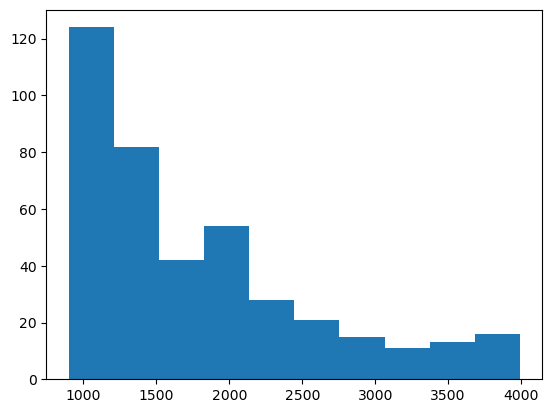

In [16]:

df_bow_sklearn = df_bow_sklearn.loc[:, (df_bow_sklearn.astype('bool').sum() >= 900) & (df_bow_sklearn.astype('bool').sum() <= 4000)]
df_bow_sklearn = df_bow_sklearn.loc[:, ~df_bow_sklearn.columns.str.contains(r'\d')]
series = df_bow_sklearn.astype('bool').sum(axis=0)
plt.hist(series)

In [17]:
df_bow_sklearn.shape,bag_nlp_df.shape

((9413, 406), (9413, 106380))

In [18]:
df_bow_sklearn.head()

abil  abl  accord  across  act  activ  actual  ad  adapt  addit  ...  \
0     0    0       1       0    0      0       0   1      0      0  ...   
1     0    0       1       1    0      0       0   0      0      3  ...   
2     0    0       2       0    0      0       0   0      0      1  ...   
3     0    0       0       0    0      0       0   0      0      1  ...   
4     0    0       0       2    0      0       0   0      0      0  ...   

   whether  wide  within  without  world  would  year  yet  âthe  âwe  
0        0     0       0        3      0      0     0    0     0    0  
1        0     1       0        1      1      0     1    0     0    0  
2        0     0       0        0      0      0     0    0     0    0  
3        0     0       0        0      2      0     0    0     0    0  
4        0     0       0        0      0      0     0    0     0    0  

[5 rows x 406 columns]

In [19]:
bag_nlp_df = pd.concat([data_df[['cat_id','level','cat_parent_id','grandparent_id']], df_bow_sklearn], axis=1)
bag_nlp_df.shape

(9413, 410)

In [20]:
bag_nlp_df.head()

cat_id  level  cat_parent_id  grandparent_id  abil  abl  accord  across  \
0    1836      3           2100            2096     0    0       1       0   
1    1836      3           2100            2096     0    0       1       1   
2    1836      3           2100            2096     0    0       2       0   
3    1836      3           2100            2096     0    0       0       0   
4    1836      3           2100            2096     0    0       0       2   

   act  activ  ...  whether  wide  within  without  world  would  year  yet  \
0    0      0  ...        0     0       0        3      0      0     0    0   
1    0      0  ...        0     1       0        1      1      0     1    0   
2    0      0  ...        0     0       0        0      0      0     0    0   
3    0      0  ...        0     0       0        0      2      0     0    0   
4    0      0  ...        0     0       0        0      0      0     0    0   

   âthe  âwe  
0     0    0  
1     0    0  
2     0    0  
3     0    0  
4     0    0  

[5 rows x 410 columns]

In [21]:
import numpy as np
import plotly.express as px
from sklearn import datasets
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
import hdbscan

n_samples = 1500
random_state = 170
X = bag_nlp_df

methods = {
    "KMeans": KMeans(n_clusters=10),
    "SpectralClustering": SpectralClustering(n_clusters=10, affinity='nearest_neighbors', assign_labels='kmeans'),
    "Hierarchical": AgglomerativeClustering(n_clusters=10),
    "DBSCAN": DBSCAN(eps=0.3),
    "HDBSCAN": hdbscan.HDBSCAN(min_cluster_size=10)
}

results = {}

for name, method in methods.items():
    results[name] = method.fit_predict(X)
#     bag_nlp_df[name] = results[name]
    
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_data = tsne.fit_transform(X)

for name, labels in results.items():
    fig = px.scatter(reduced_data, color=labels, title=name)
    fig.show()


In [22]:
reduced_data

array([[-55.515392, -51.41046 ],
       [-55.51141 , -51.445393],
       [-55.44332 , -51.41035 ],
       ...,
       [-29.998854,  37.196846],
       [-29.999222,  37.199368],
       [ -8.351171,  75.69583 ]], dtype=float32)

In [23]:

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
silhouette = silhouette_score(reduced_data, results['KMeans'])
davies_bouldin = davies_bouldin_score(reduced_data,results['KMeans'])
calinski_harabasz = calinski_harabasz_score(reduced_data, results['KMeans'])

silhouette,davies_bouldin, calinski_harabasz

(0.23425758, 2.455197495325674, 2616.7948940796787)

In [24]:
silhouette = silhouette_score(reduced_data, results['SpectralClustering'])
davies_bouldin = davies_bouldin_score(reduced_data,results['SpectralClustering'])
calinski_harabasz = calinski_harabasz_score(reduced_data, results['SpectralClustering'])

silhouette,davies_bouldin, calinski_harabasz

(-0.0670781, 1.8192952776692632, 437.2077539855647)

In [25]:
silhouette = silhouette_score(reduced_data, results['Hierarchical'])
davies_bouldin = davies_bouldin_score(reduced_data,results['Hierarchical'])
calinski_harabasz = calinski_harabasz_score(reduced_data, results['Hierarchical'])

silhouette,davies_bouldin, calinski_harabasz

(0.24831773, 2.633058789667532, 2779.687885214681)

In [26]:
silhouette = silhouette_score(reduced_data, results['DBSCAN'])
davies_bouldin = davies_bouldin_score(reduced_data,results['DBSCAN'])
calinski_harabasz = calinski_harabasz_score(reduced_data, results['DBSCAN'])

silhouette,davies_bouldin, calinski_harabasz

(-0.6297714, 2.9770783646762786, 13.85503933696758)

In [27]:
silhouette = silhouette_score(reduced_data, results['HDBSCAN'])
davies_bouldin = davies_bouldin_score(reduced_data,results['HDBSCAN'])
calinski_harabasz = calinski_harabasz_score(reduced_data, results['HDBSCAN'])

silhouette,davies_bouldin, calinski_harabasz

(-0.03834401, 1.1809146947183344, 1135.2210694629161)

In [28]:
results

{'KMeans': array([6, 6, 6, ..., 5, 5, 5], dtype=int32),
 'SpectralClustering': array([1, 1, 1, ..., 8, 8, 4], dtype=int32),
 'Hierarchical': array([7, 7, 7, ..., 2, 2, 2]),
 'DBSCAN': array([-1, -1, -1, ..., -1, -1, -1]),
 'HDBSCAN': array([6, 6, 6, ..., 2, 2, 2])}

In [29]:
len(feature_names_list)

106366

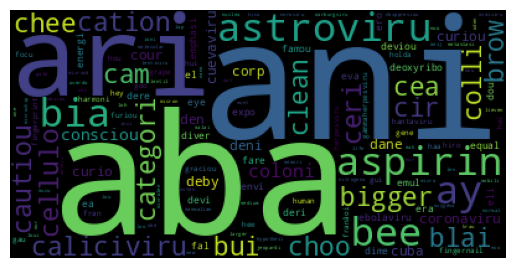

In [30]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
word_cloud =WordCloud().generate(' '.join(feature_names_list))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [31]:
data_df.columns

Index(['id', 'title', 'introtext', 'fulltext', 'cat_id', 'class_2', 'level',
       'cat_parent_id', 'parent_title', 'grandparent_id', 'grandparent_title',
       'title_cleaned', 'introtext_cleaned', 'fulltext_cleaned'],
      dtype='object')

In [32]:
bag_nlp_df

cat_id  level  cat_parent_id  grandparent_id  abil  abl  accord  across  \
0       1836      3           2100            2096     0    0       1       0   
1       1836      3           2100            2096     0    0       1       1   
2       1836      3           2100            2096     0    0       2       0   
3       1836      3           2100            2096     0    0       0       0   
4       1836      3           2100            2096     0    0       0       2   
...      ...    ...            ...             ...   ...  ...     ...     ...   
9408    2145      3           2141            2096     4    0       1       1   
9409    2148      3           2141            2096     0    1       1       0   
9410    2149      3           2093            2096     0    0       0       0   
9411    2149      3           2093            2096     1    0       0       0   
9412    2150      3           2127            2096     0    0       0       0   

      act  activ  ...  whether  wide  within  without  world  would  year  \
0       0      0  ...        0     0       0        3      0      0     0   
1       0      0  ...        0     1       0        1      1      0     1   
2       0      0  ...        0     0       0        0      0      0     0   
3       0      0  ...        0     0       0        0      2      0     0   
4       0      0  ...        0     0       0        0      0      0     0   
...   ...    ...  ...      ...   ...     ...      ...    ...    ...   ...   
9408    0      0  ...        0     1       0        0      0      0     0   
9409    0      1  ...        0     0       1        1      0      0     0   
9410    0      0  ...        0     0       0        1      0      0     1   
9411    0      0  ...        0     0       0        0      0      0     0   
9412    0      1  ...        0     0       0        1      0      1     1   

      yet  âthe  âwe  
0       0     0    0  
1       0     0    0  
2       0     0    0  
3       0     0    0  
4       0     0    0  
...   ...   ...  ...  
9408    0     0    0  
9409    0     0    0  
9410    0     0    0  
9411    0     0    0  
9412    0     1    0  

[9413 rows x 410 columns]

In [33]:
bag_nlp_df['kmeans']=results['KMeans']
bag_nlp_df.head()

cat_id  level  cat_parent_id  grandparent_id  abil  abl  accord  across  \
0    1836      3           2100            2096     0    0       1       0   
1    1836      3           2100            2096     0    0       1       1   
2    1836      3           2100            2096     0    0       2       0   
3    1836      3           2100            2096     0    0       0       0   
4    1836      3           2100            2096     0    0       0       2   

   act  activ  ...  wide  within  without  world  would  year  yet  âthe  âwe  \
0    0      0  ...     0       0        3      0      0     0    0     0    0   
1    0      0  ...     1       0        1      1      0     1    0     0    0   
2    0      0  ...     0       0        0      0      0     0    0     0    0   
3    0      0  ...     0       0        0      2      0     0    0     0    0   
4    0      0  ...     0       0        0      0      0     0    0     0    0   

   kmeans  
0       6  
1       6  
2       6  
3       6  
4       6  

[5 rows x 411 columns]

In [34]:
bag_nlp_df.to_csv('final_data.csv')

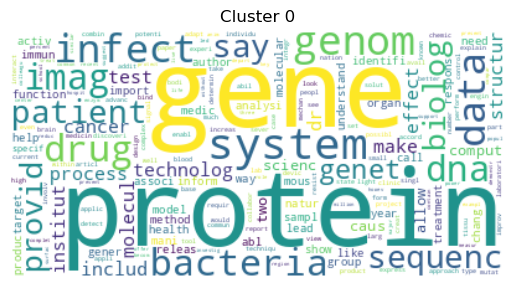

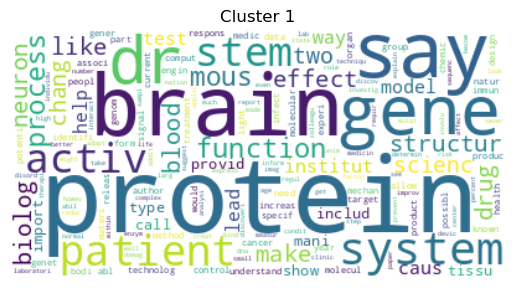

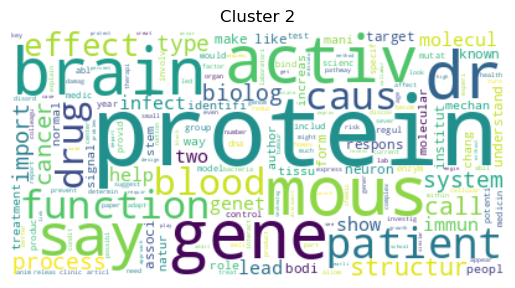

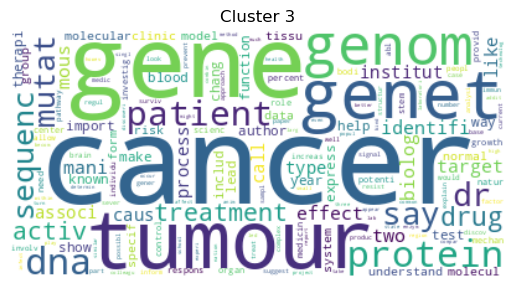

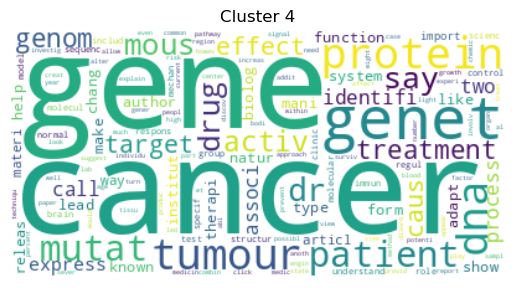

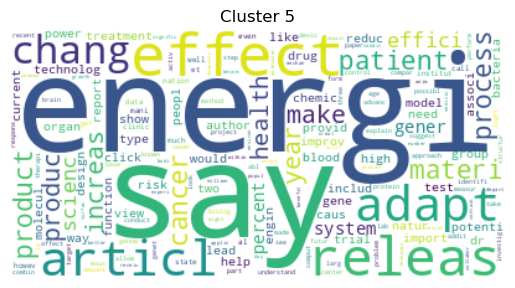

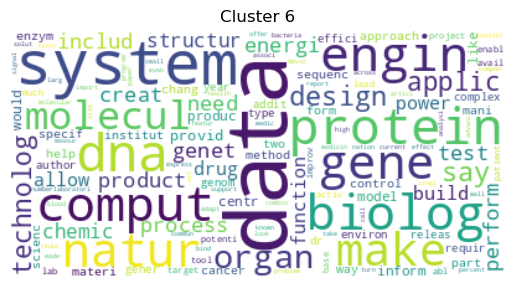

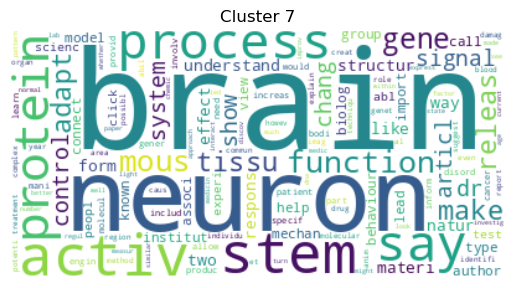

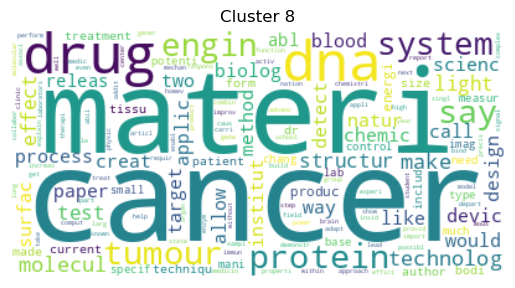

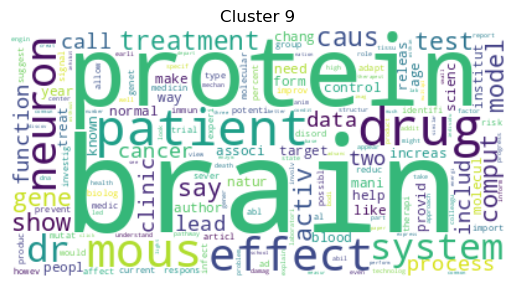

In [35]:
temp = bag_nlp_df.drop(columns=['cat_id', 'level','cat_parent_id','grandparent_id'])
grouped = temp.groupby('kmeans').sum()
for cluster, row in grouped.iterrows():
    words = {}
    for word, value in row.iteritems():
        words[word] = value
    
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(words)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {cluster}")
    plt.show()

In [36]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Assuming data is loaded as `df` and target column is 'target'
# Convert the target to string if they're not
bag_nlp_df['cat_parent_id'] = bag_nlp_df['cat_parent_id'].astype(str)

X = bag_nlp_df.drop(columns=['cat_parent_id','kmeans'])
y = bag_nlp_df['cat_parent_id']

# Binarize target for ROC
lb = LabelBinarizer()
y_bin = lb.fit_transform(y)

# Initialize classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier())
]

# Data Collection
metrics_data = []
roc_data = []

# Model Training, Prediction & Metric Calculation
for name, clf in classifiers:
    clf.fit(X, y)
    predictions = clf.predict(X)
    report = classification_report(y, predictions, output_dict=True, zero_division=1)
    
    # Collecting metrics data
    for target_class in lb.classes_:
        metrics_data.append((name, target_class, report[target_class]['precision'], report[target_class]['recall'], report[target_class]['f1-score']))
        
    # ROC and AUC for multi-class (One-vs-All approach)
    y_prob = clf.predict_proba(X)
    for idx, target_class in enumerate(lb.classes_):
        fpr, tpr, _ = roc_curve(y_bin[:, idx], y_prob[:, idx])
        auc = roc_auc_score(y_bin[:, idx], y_prob[:, idx])
        roc_data.append((name, target_class, fpr, tpr, auc))
        
# Convert results to DataFrame for visualization
df_metrics = pd.DataFrame(metrics_data, columns=["Classifier", "Class", "Precision", "Recall", "F1-Score"])

# Visualizations
# Bar charts for metrics
fig = px.bar(df_metrics, x="Classifier", y=["Precision", "Recall", "F1-Score"], color="Class", barmode="group", title="Classification Metrics Comparison")
fig.show()

# ROC Curves
fig = go.Figure()
for name, target_class, fpr, tpr, auc in roc_data:
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=f'{name} - Class {target_class} (AUC: {auc:.2f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Baseline', line=dict(dash='dash')))
fig.update_layout(title="ROC Curve", xaxis_title="False Positive Rate", yaxis_title="True Positive Rate", xaxis=dict(scaleanchor="y", scaleratio=1), yaxis=dict(scaleanchor="x", scaleratio=1))
fig.show()


In [37]:
len(y_prob),y_prob[0]

(9413,
 array([0.  , 0.  , 0.  , 0.15, 0.  , 0.  , 0.02, 0.01, 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.8 , 0.  , 0.02, 0.  , 0.  ]))

In [38]:
results

{'KMeans': array([6, 6, 6, ..., 5, 5, 5], dtype=int32),
 'SpectralClustering': array([1, 1, 1, ..., 8, 8, 4], dtype=int32),
 'Hierarchical': array([7, 7, 7, ..., 2, 2, 2]),
 'DBSCAN': array([-1, -1, -1, ..., -1, -1, -1]),
 'HDBSCAN': array([6, 6, 6, ..., 2, 2, 2])}

In [39]:
report

{'1864': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 462},
 '1867': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 385},
 '1875': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 306},
 '2008': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1457},
 '2009': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 35},
 '2010': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1286},
 '2011': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 436},
 '2034': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 371},
 '2040': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 151},
 '2060': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 619},
 '2073': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 142},
 '2083': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 222},
 '2093': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 106}

In [40]:
metrics_data

[('Logistic Regression',
  '1864',
  0.5299760191846523,
  0.47835497835497837,
  0.5028441410693971),
 ('Logistic Regression',
  '1867',
  0.5722713864306784,
  0.5038961038961038,
  0.5359116022099447),
 ('Logistic Regression',
  '1875',
  0.7323076923076923,
  0.7777777777777778,
  0.7543581616481775),
 ('Logistic Regression',
  '2008',
  0.7533449680046539,
  0.8888126286890872,
  0.8154911838790931),
 ('Logistic Regression', '2009', 1.0, 0.0, 0.0),
 ('Logistic Regression',
  '2010',
  0.5991271820448878,
  0.7472783825816485,
  0.6650519031141868),
 ('Logistic Regression',
  '2011',
  0.6265822784810127,
  0.4541284403669725,
  0.526595744680851),
 ('Logistic Regression',
  '2034',
  0.5081967213114754,
  0.41778975741239893,
  0.45857988165680474),
 ('Logistic Regression',
  '2040',
  0.6875,
  0.5827814569536424,
  0.6308243727598567),
 ('Logistic Regression',
  '2060',
  0.6795252225519288,
  0.7399030694668821,
  0.7084300077339521),
 ('Logistic Regression', '2073', 0.50354609

In [41]:
bag_nlp_df.cat_parent_id.unique()

array(['2100', '1864', '2128', '2008', '2011', '2096', '2097', '2010',
       '2093', '1867', '2034', '2060', '1875', '2040', '2073', '2083',
       '2098', '2009', '2129', '2141', '2127'], dtype=object)

In [42]:
X

cat_id  level  grandparent_id  abil  abl  accord  across  act  activ  \
0       1836      3            2096     0    0       1       0    0      0   
1       1836      3            2096     0    0       1       1    0      0   
2       1836      3            2096     0    0       2       0    0      0   
3       1836      3            2096     0    0       0       0    0      0   
4       1836      3            2096     0    0       0       2    0      0   
...      ...    ...             ...   ...  ...     ...     ...  ...    ...   
9408    2145      3            2096     4    0       1       1    0      0   
9409    2148      3            2096     0    1       1       0    0      1   
9410    2149      3            2096     0    0       0       0    0      0   
9411    2149      3            2096     1    0       0       0    0      0   
9412    2150      3            2096     0    0       0       0    0      1   

      actual  ...  whether  wide  within  without  world  would  year  yet  \
0          0  ...        0     0       0        3      0      0     0    0   
1          0  ...        0     1       0        1      1      0     1    0   
2          0  ...        0     0       0        0      0      0     0    0   
3          0  ...        0     0       0        0      2      0     0    0   
4          0  ...        0     0       0        0      0      0     0    0   
...      ...  ...      ...   ...     ...      ...    ...    ...   ...  ...   
9408       0  ...        0     1       0        0      0      0     0    0   
9409       0  ...        0     0       1        1      0      0     0    0   
9410       0  ...        0     0       0        1      0      0     1    0   
9411       0  ...        0     0       0        0      0      0     0    0   
9412       0  ...        0     0       0        1      0      1     1    0   

      âthe  âwe  
0        0    0  
1        0    0  
2        0    0  
3        0    0  
4        0    0  
...    ...  ...  
9408     0    0  
9409     0    0  
9410     0    0  
9411     0    0  
9412     1    0  

[9413 rows x 409 columns]